# E-commerce — Анализ товарного ассортимента

**Материалы:**

Ссылка на дашборд: <https://public.tableau.com/app/profile/kseniia.savinkova/viz/YP_final_project_16830282133040/Dashboard1>

Ссылка на презентацию: <https://disk.yandex.ru/i/6EAP8STRSFKtxA>

**Цель исследования:** на основе транзакций интернет-магазина товаров для дома и быта «Пока все ещё тут» проанализировать товарный ассортимент, выделить среди него основной и дополнительный.

**Ход исследования:**
1. Изучение общей информации. Предобработка данных:
    - проверить типы данных
    - проверить наличие пропусков и дубликатов
    - проверить ошибки в данных
    
2. Исследовательский анализ данных
    - добавить столбец `revenue` доход с товарной единицы (цена х количество)
    - добавить столбец: `month`, `day_of_week`, `hour`
    - разделить товары на категории по наименованию 
    - для каждой категории найти основные показатели: средний чек, общий доход
    - определить сезонность товаров: построить распределения количества заказов категорий по месяцам, общей выручки с категории по месяцам

    2.1 Анализ товарного ассортимента. ABC-XYZ-анализ
      - разделить товары по выручке
      - разделить товары по количеству продаж
      - выделить основной и дополнительный ассортимент
        
3. Сформулировать и проверить статистические гипотезы
    
4. Создать дашборд, основные графики:
    - диаграмма, отображающая сумму покупок по дням.
    - гистограмма, отображающая распределение заказов по сумме.
    - добавить фильтр дашборда по дате совершения покупки.
5. Подготовить презентацию

## Изучение общей информации. Предобработка данных

Импортируем библиотеки необходимые нам в решении задач исследования.

In [1]:
import pandas as pd
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

In [2]:
#улучшим четкость изображения графиков
%config InlineBackend.figure_format = 'retina'

In [3]:
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

In [4]:
pip install kaleido

Ознакомимся с данными:

In [5]:
#записываем исследуемый датасет в переменную data
data = pd.read_csv('https://code.s3.yandex.net/datasets/ecommerce_dataset.csv')

print('Первые 5 строк исследуемого датасета')
display(data.head())
print('Информация о хранящихся в нем данных:')
data.info()

Первые 5 строк исследуемого датасета


,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Информация о хранящихся в нем данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


Описание данных:
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

По первому взгляду на датасет можно сделать следующие **выводы:**
* типы данных не соответствуют сохраненным в них значениям: столбец с датами определен как тип данных `int64`
* наименования столбцов удобны для дальнейшей работы и не требуют предобработки.

Проведем необходимую предобработку: изменим тип даты в столбце `date`, проверим датасет на наличие пропусков и дубликатов.

In [6]:
#преобразование данных о времени
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

In [7]:
#проверим датасет на наличие явных дубликатов
print(f'Количество явных дубликатов: {data.duplicated().sum()}')

#проверим датасет на наличие пропущенных значений
#вспомогательная переменная, перенос строки
nl = '\n'
print(f'Количество пропущенных значений:{nl}{data.isna().sum()}')

Количество явных дубликатов: 0
Количество пропущенных значений:
date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64


Явных дубликатов и пропущенных значений нет.

Произведем проверку данных на ошибки. Проверим соответствие идентификатора заказа одному идентификатору покупателя (1 заказ не может быть оформлен 2-мя или более покупателями)

In [8]:
#группируем датасет по идентификатору заказа, считаем количество уникальных идентификаторов покупателя
#делаем срез заказов с количество покупателей >1

bug_orders = data.pivot_table(
    index = 'order_id', 
    values = 'customer_id', 
    aggfunc = 'nunique').query('customer_id > 1').reset_index()

print(f'Количество заказов с ошибками: {bug_orders.shape[0]}')

bug_orders_ratio = round(bug_orders.shape[0] / data['order_id'].nunique() * 100, 2)
print(f'Доля заказов с ошибками: {bug_orders_ratio} %')

Количество заказов с ошибками: 29
Доля заказов с ошибками: 1.04 %


In [9]:
#посмотрим подробнее на заказы с ошибками
pd.set_option('display.max_rows', 500)

bug_orders_id = bug_orders['order_id'].tolist()
data.query('order_id in @bug_orders_id').sort_values(by=['order_id', 'customer_id']).head(10)

,date,customer_id,order_id,product,quantity,price
5518,2019-06-21 22:00:00,4e861452-b692-48dc-b756-99a130b7a70a,14872,Однолетнее растение Петуния махровая в кассете...,2,82.0
5519,2019-06-21 22:00:00,4e861452-b692-48dc-b756-99a130b7a70a,14872,Однолетнее растение Петуния простая в кассете ...,1,82.0
5520,2019-06-21 22:00:00,4e861452-b692-48dc-b756-99a130b7a70a,14872,Петуния махровая рассада однолетних цветов в к...,1,128.0
5545,2019-06-22 22:00:00,4e861452-b692-48dc-b756-99a130b7a70a,14872,Однолетнее растение Петуния махровая в кассете...,2,82.0
5546,2019-06-22 22:00:00,4e861452-b692-48dc-b756-99a130b7a70a,14872,Однолетнее растение Петуния простая в кассете ...,1,82.0
5547,2019-06-22 22:00:00,4e861452-b692-48dc-b756-99a130b7a70a,14872,Петуния махровая рассада однолетних цветов в к...,1,128.0
5549,2019-06-24 09:00:00,9897ccd6-9441-4886-b709-b06361fabf6c,14872,Однолетнее растение Петуния махровая в кассете...,2,82.0
5550,2019-06-24 09:00:00,9897ccd6-9441-4886-b709-b06361fabf6c,14872,Однолетнее растение Петуния простая в кассете ...,1,82.0
5551,2019-06-24 09:00:00,9897ccd6-9441-4886-b709-b06361fabf6c,14872,Петуния махровая рассада однолетних цветов в к...,1,128.0
512,2018-10-28 22:00:00,0b5ce2c7-acef-4a9a-b821-61a44ed05557,68785,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.0


Действительно некоторым заказам соответствуют несколько покупателей. Удалим данные о таких заказах.

In [10]:
data = data.query('order_id not in @bug_orders_id')

Проверим соответствие дате заказа одному идентификатору заказа и одному идентификатору покупателя

In [11]:
#группируем датасет по идентификатору заказа и идентификатору покупателя
#считаем количество уникальных дат
#делаем срез заказов с датой >1

bug_dates = data.pivot_table(
    index = ['order_id', 'customer_id'], 
    values = 'date', 
    aggfunc = 'nunique').query('date > 1').reset_index()

print(f'Количество заказов с ошибками в датах: {bug_dates.shape[0]}')

bug_dates_ratio = round(bug_dates.shape[0] / data['order_id'].nunique() * 100, 2)
print(f'Доля заказов с ошибками: {bug_dates_ratio} %')

Количество заказов с ошибками в датах: 256
Доля заказов с ошибками: 9.29 %


In [12]:
#посмотрим подробнее на заказы с ошибками в датах
pd.set_option('display.max_rows', 2400)

bug_dates_id = bug_dates['order_id'].tolist()
bug_dates_data = data.query('order_id in @bug_dates_id').sort_values(by=['order_id', 'date'])
bug_dates_data.head(10)

,date,customer_id,order_id,product,quantity,price
102,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0
103,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0
104,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0
376,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0
377,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0
378,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0
509,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0
510,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0
511,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0
588,2018-11-02 14:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0


Скорее всего мы столкнулись с техническими ошибками записи/выгрузки данных: будем считать, что покупатель оформил заказ не сразу и в нашу выгрузку попали данные о его промежуточных шагах. Оставим данные об этих заказах с датой последнего шага (т.е. максимальной датой), остальные удалим.

In [13]:
#удалим из основного датасета заказы с ошибками в датах
#вспомогательная переменная data1
data1 = data.query('order_id not in @bug_dates_id')

#сохраним в отдельную переменную пары id заказа - последняя дата этого заказа
last_date_id = bug_dates_data.groupby('order_id')['date'].max()
#уберем немаксимальные даты из таблицы заказов с ошибками в датах, сохраним во вспомогательной переменной data2
data2 = bug_dates_data.merge(last_date_id, on=['order_id','date'])

#конкатенируем data1 и data2
data = pd.concat([data1, data2])

**Вывод:** при первичном знакомстве с данными и оценке их качества были выявлены ошибки в данных:
* несоответствие 1 идентификатору пользователя 1 идентификатора заказа (доля ошибочных данных составила чуть более 1%), эти данные были удалены
* несоответствие 1 даты заказа 1 заказу (доля ошибочных данных более 9%), в результате предобработки были оставлены данные соответствующие максимальной дате по таким заказам.

## Исследовательский анализ данных

Определим некоторую справочную информацию о наших данных:

In [14]:
#временные рамки
print('Минимальная дата исследуемых данных:', data['date'].min())
print('Максимальная дата исследуемых данных:', data['date'].max())
 
#справка о заказах
print('Общее количество заказов:', data['order_id'].nunique())
print('Общее количество уникальных товаров:', data['product'].nunique())
print('Количество в среднем товаров на 1 заказ:', \
      round(data.groupby('order_id')['product'].agg('count').mean(), 0))

Минимальная дата исследуемых данных: 2018-10-01 00:00:00
Максимальная дата исследуемых данных: 2019-10-31 16:00:00
Общее количество заказов: 2755
Общее количество уникальных товаров: 2322
Количество в среднем товаров на 1 заказ: 2.0


Мы располагаем данными в период с 1 октября 2018 года по 31 октября 2019 года. Датасет содержит информацию о 2755 заказах.

Проверим датасет на наличие выбросов и аномальных значений. Оценим как распределяются некоторые числовые значения датасета - количество единицы товара в заказе и его стоимость.

,count,mean,std,min,50%,95%,99%,max
quantity,4749.0,2.818488,17.786549,1.0,1.0,7.0,30.0,1000.0


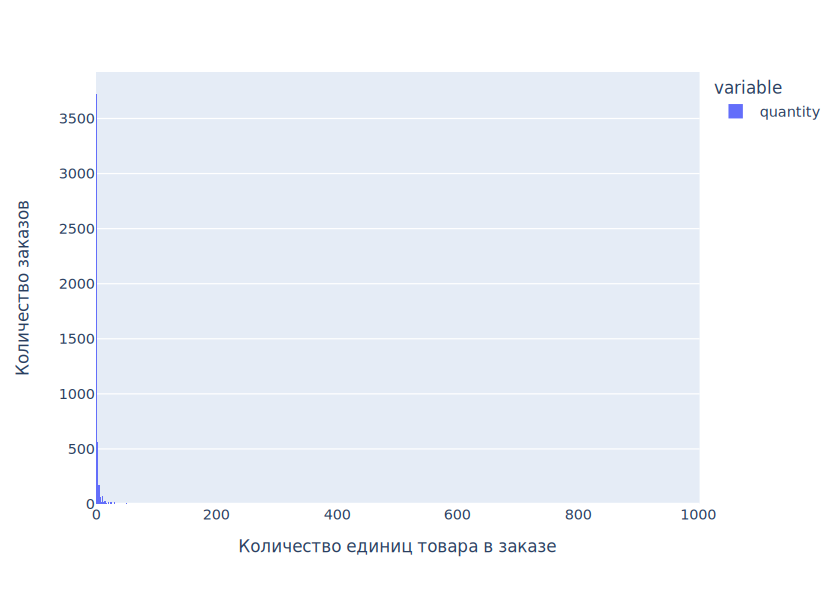

In [15]:
#статистические данные о распределении значений количества
display(data.describe([0.95, 0.99])[['quantity']].T)

#гистограмма
fig = px.histogram(data['quantity'])
#оформление графика
fig.update_layout(xaxis_title='Количество единиц товара в заказе',
                  yaxis_title='Количество заказов')
fig.show()

В 99% случаев количество товара не превышает 30 шт, посмотрим на товары количество которых > 30 единиц.

In [16]:
#таблица товаров количество которых >30
data.query('quantity > 30').sort_values(by='quantity')

,date,customer_id,order_id,product,quantity,price
2531,2019-03-28 20:00:00,bba9b7bf-09a6-4f16-81c3-2b83dcebbc0a,70915,Цветок искусственный Гвоздика тканевая красная...,31,20.0
144,2018-10-08 15:00:00,9151d307-654c-4239-a888-ada5ca45f0b2,68571,Набор вешалок для костюма 45см 4шт цвет: кремо...,37,202.0
5591,2019-06-25 21:00:00,72df1c3c-6efc-45c5-9b12-5a48935a48a4,71802,"Петля приварная гаражная d 14х90 мм с шаром, 1...",40,38.0
1316,2018-12-23 11:00:00,24c0b355-53e3-428a-b299-e1627b1cdd5c,69524,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
2371,2019-03-18 10:00:00,21b4642e-9cdf-4738-a290-b42d3e748c0f,70776,Гвоздика стандартная Белая 60 см Колумбия План...,43,29.0
1568,2019-01-22 15:00:00,6be74251-7159-4cc0-99fb-d034a17c61b0,69928,Спатифиллум Шопен d-12 см,45,250.0
6684,2019-10-23 11:00:00,2fac41bf-e800-4bc3-a4b3-0df800f33e99,73073,"Ведро резинопластиковое строительное 12,0 л (М...",50,64.0
6678,2019-10-22 16:00:00,511115b7-e981-4069-9e0e-88a3551341a6,73063,Муляж Яблоко зеленый 9 см полиуретан,50,51.0
242,2018-10-17 13:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68668,Щетка для посуды *Мила* SV3182 1807009,50,27.0
2049,2019-02-27 09:00:00,377c8a20-a3e0-4945-9fd8-a1f4ada5d8b0,70482,Муляж Банан желтый 21 см полиуретан,50,51.0


Так как в 99% случаев количество единиц товарной позиции в заказе не превышают 30, исключим заказы с `quantity` > 30 шт, так мы избавимся от нетипичных оптовых клиентов:

In [17]:
#исключаем аномальные заказы
data = data[data['quantity'] <= 30]

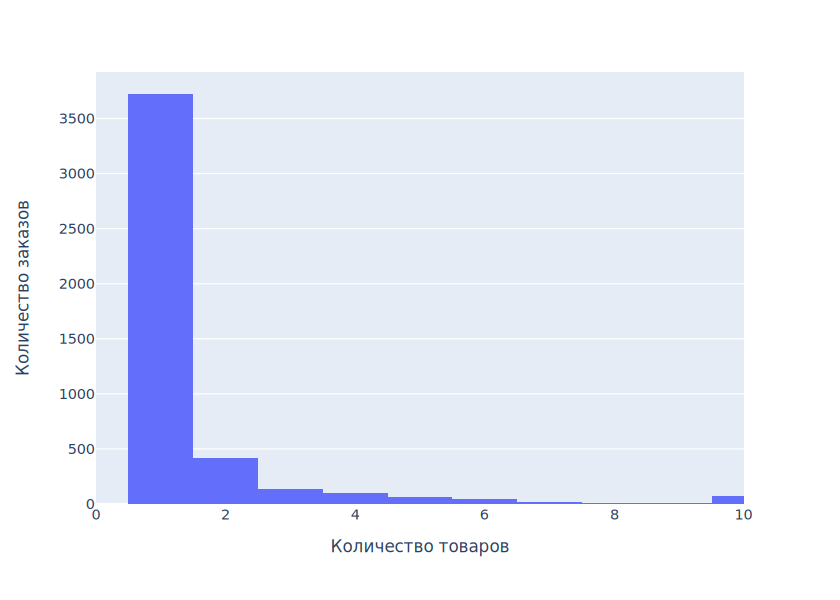

In [18]:
#гистограмма с увеличенным масштабом
fig = px.histogram(data['quantity'], range_x=(0,10))
#оформление графика
fig.update_layout(xaxis_title='Количество товаров',
                  yaxis_title='Количество заказов',
                  showlegend=False)
fig.show()

Подавляющее большинство товаров продаются в количестве 1 единицы на заказ.

,count,mean,std,min,50%,95%,99%,max
price,4712.0,520.233022,952.318916,9.0,150.0,2249.0,5016.63,14917.0


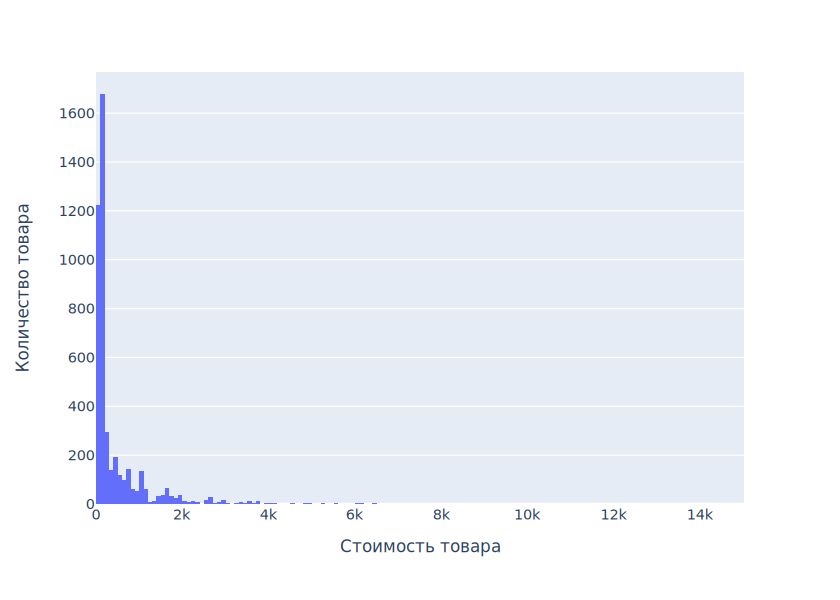

In [19]:
#оценим как распределяются значения стоимостей товаров
#статистические данные о распределении значений
display(data.describe([0.95, 0.99])[['price']].T)

#гистограмма
fig = px.histogram(data['price'])
#оформление графика
fig.update_layout(xaxis_title='Стоимость товара',
                  yaxis_title='Количество товара',
                  showlegend=False)
fig.show()

В 99% случаев стоимость товара не превышает 5000 рублей, посмотрим на товары стоимость которых > 5000.

In [20]:
#таблица товаров стоимость которых >5000
data.query('price > 5000').sort_values(by='price')

,date,customer_id,order_id,product,quantity,price
98,2018-10-04 17:00:00,d1a13243-9111-454f-848c-dcce0958528c,68529,Сумка-тележка хозяйственная Andersen Scala Sho...,1,5024.0
596,2018-11-02 17:00:00,305c9634-ec53-46be-af05-48ee8bd790a5,68836,Сумка-тележка хозяйственная Andersen Scala Sho...,1,5249.0
2806,2019-04-12 07:00:00,fa415301-e3f2-4eb3-a7b2-d0a257591c9d,71113,Сумка-тележка хозяйственная Andersen Scala Sho...,1,5249.0
282,2018-12-06 17:00:00,fa471f6f-1442-490c-acc6-a47b0822098c,69226,Сумка-тележка хозяйственная Andersen Scala Sho...,1,5249.0
2229,2019-03-07 08:00:00,f4870400-e54c-4b7f-b95c-0ccba252bf39,70648,Сумка-тележка хозяйственная Andersen Scala Sho...,1,5249.0
1652,2019-02-01 16:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70060,Сумка-тележка хозяйственная Andersen Scala Sho...,1,5249.0
2599,2019-04-02 10:00:00,34a0ed26-edc1-449b-9229-e0c199460721,70973,"Урна-пепельница из нержавеющей стали, Hobbyka/...",1,5287.0
6100,2019-08-15 13:00:00,16e422c6-94fe-4ccf-9c97-05493f3e99c4,72302,Набор инструментов в алюминиевом кейсе на коле...,1,5399.0
1463,2019-01-10 06:00:00,d5f66ed0-44c2-4147-9d25-313312a23cba,69758,Комплект для мытья полов из нержавеющей стали ...,1,5399.0
2208,2019-03-06 12:00:00,b16a52b7-499b-4be8-9220-19076ed22bc9,70627,Сумка-тележка хозяйственная Rolser MOUNTAIN че...,1,5459.0


Стоимости товаров выглядят правдаподобно, выбросов нет.

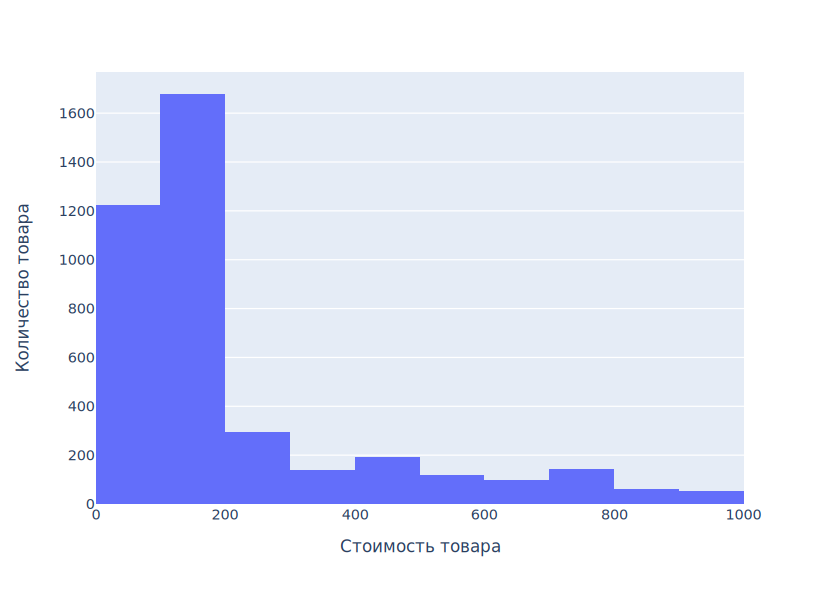

In [21]:
#гистограмма с увеличенным масштабом
fig = px.histogram(data['price'], range_x=(0,1000))
#оформление графика
fig.update_layout(xaxis_title='Стоимость товара',
                  yaxis_title='Количество товара',
                  showlegend=False)
fig.show()

Стоимость подавляющего большинства товаров не превышает 200 рублей.

Добавим дополнительные столбцы, необходимые нам в дальнейшем исследовании:
* `revenue` - доход с товарной единицы (цена х количество)
* `month` - месяц заказа
* `day_of_week` - день недели заказа
* `hour` - час заказа

In [22]:
#доход с товарной единицы
data['revenue'] = data['price']*data['quantity']

#день недели заказа (0 - понедельник, 1 - вторник и т.д.):
data['day_of_week'] = pd.DatetimeIndex(data['date']).weekday

#час заказа:
data['hour'] = pd.DatetimeIndex(data['date']).hour

#приводим к временному формату
data['date'] = data['date'].dt.date 

#месяц заказа:
data['month'] = data['date'].astype('datetime64[M]') 

,count,mean,std,min,50%,95%,99%,max
revenue,4712.0,666.813667,1378.72514,9.0,190.0,2699.0,5928.88,47385.0


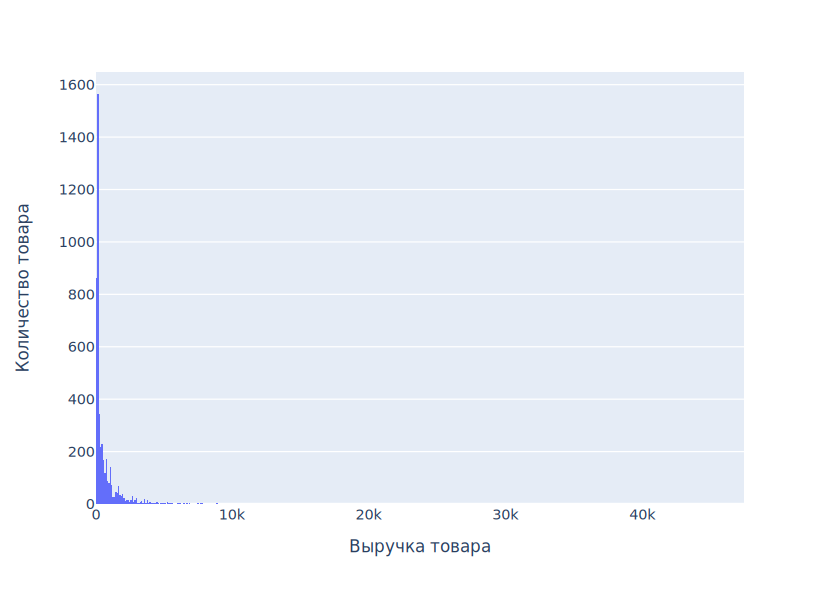

In [23]:
#оценим как распределяются значения выручки
#статистические данные о распределении значений
display(data.describe([0.95, 0.99])[['revenue']].T)

#гистограмма
fig = px.histogram(data['revenue'])
#оформление графика
fig.update_layout(xaxis_title='Выручка товара',
                  yaxis_title='Количество товара',
                  showlegend=False)
fig.show()

В 99% случаев выручка с 1 позиции товара в заказе не превышает 6000 рублей, посмотрим на товары выручка с которых > 15000.

In [24]:
#таблица товаров стоимость которых >15000
data.query('revenue > 15000').sort_values(by='revenue')

,date,customer_id,order_id,product,quantity,price,revenue,day_of_week,hour,month
2971,2019-04-19,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71206,Одеяло Wellness T142 белое темостеганое 140х20...,10,1568.0,15680.0,4,19,2019-04-01
1675,2019-02-04,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,70080,Мусорный контейнер Hailo BigBin Swing 45 0845-...,3,5512.0,16536.0,0,6,2019-02-01
661,2018-11-06,1b2764ad-9151-4051-a46a-9b01b62e6335,68878,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см...",5,4874.0,24370.0,1,12,2018-11-01
1518,2019-01-15,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,Простынь вафельная 200х180 см WELLNESS RW180-0...,27,1755.0,47385.0,1,13,2019-01-01


Значения выручки не превышают 50000 рублей. 

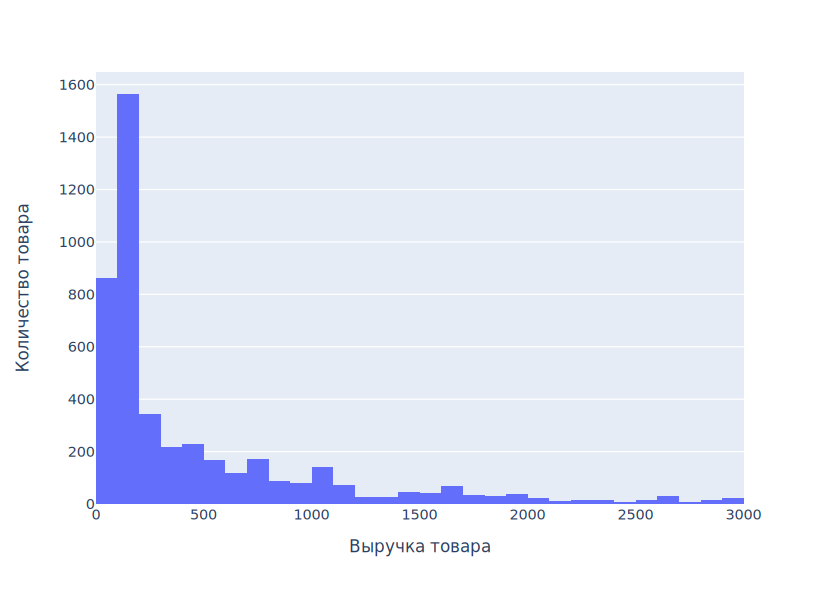

In [25]:
#гистограмма с увеличенным масштабом
fig = px.histogram(data['revenue'], range_x=(0,3000))
#оформление графика
fig.update_layout(xaxis_title='Выручка товара',
                  yaxis_title='Количество товара',
                  showlegend=False)
fig.show()

Подавляющее большинство товаров имеют выручку в 1 заказе не более 250 рублей.

## Анализ товарных категорий

Разобьем товары на категории:

In [26]:
#приведем наименования к нижнему регистру
data['product'] = data['product'].str.lower()

#выделим первое слово из названия продукта для составления функции
first_word = data['product'].astype(str).apply(lambda x: x.split()[0])
display(first_word.unique())

#аналогично выделим второе слово из названия продукта
second_word = data['product'].astype(str).apply(lambda x: x.split()[1])
second_word.unique()

array(['комнатное', 'радермахера', 'хризолидокарпус', 'циперус',
       'шеффлера', 'юкка', 'настенная', 'таз', 'чехол', 'вешалка',
       'сушилка', 'корзина', 'сумка-тележка', 'многолетнее', 'рассада',
       'муляж', 'щетка-сметка', 'сумка', 'тарелка', 'вилка', 'ложка',
       'нож', 'герань', 'ерш', 'пеларгония', 'котел', 'суккулент',
       'эхеверия', 'набор', 'коврик', 'подкладка', 'дозатор', 'ёрш',
       'цветок', 'мусорный', 'плед', 'скатерть', 'кувшин', 'адиантум',
       'ковер', 'перчатки', 'стремянка', 'гладильная',
       'лестница-стремянка', 'толкушка', 'тележка', 'готовая',
       'искусственный', 'простыня', 'чайник', 'штора', 'банка', 'крючок',
       'комплект', 'стяжка', 'кампанула', 'декоративная', 'противень',
       'калатея', 'нолина', 'плечики', 'подушка', 'полотенце',
       'хлорофитум', 'цикламен', 'глоксиния', 'азалия', 'гортензия',
       'хризантема', 'стеклянная', 'салфетка', 'вкладыши', 'миксер',
       'кофр', 'стиральный', 'чистящий', 'tepмокружка',

array(['растение', 'd-12', 'лутесценс', 'зумула', 'лузеана', 'нитчатая',
       'сушилка', 'пластмассовый', 'для', 'eurogold', 'мягкая', '2-х',
       'зелени', '"райские', 'банан,', 'виноград', 'гранат', 'груша',
       'груша,', 'зеленое', 'клубника', 'красное', 'лимон,', 'мандарин,',
       'перец,', 'персики', 'томат,', 'черешня', '3-х', '4-х',
       'обеденная', 'столовая', 'чайная', 'столовый', 'домашняя',
       'зональная', 'алюминиевый', 'микс', 'перл', 'прищепок',
       'придверный', 'bacchetta', 'пластиковая', 'под', 'кружек',
       'интерьерный', 'унитазный', 'виноград,', 'вишня,', 'персик,',
       'фужеров', 'искусственный', 'хозяйственная', 'контейнер',
       'флисовый', 'династия', 'хлопковый', 'перец', 'лиза', 'латексные',
       'алюминиевая', 'доска', 'dogrular', 'багажная', 'скатерть',
       'цветок', 'на', 'эмалированный', 'текстильная', 'со', 'одежный',
       'ковров', 'оконная', 'апельсин', 'яблоко', 'махровая', 'душистая',
       'композиция', 'прямоугольн

Разделим товары на 6 категорий по наиболее часто встречающимся словам:
* интерьер
* растения и рассада
* кухня
* ванная
* ремонт
* хоз.товары

In [27]:
#напишем функцию, которая будет определять категорию по входящим фрагментам слов в наименование товара
def categorize(row):
    try:
        if 'муляж' in row or 'штор' in row or 'декор' in row or 'ковр' in row \
        or 'скатер' in row or 'искусств' in row or 'плед' in row or 'ковер' in row \
        or 'светил' in row or 'простын' in row or 'покрывал' in row or 'полк' in row \
        or 'одея' in row or 'этажерка' in row or 'постел' in row or 'комод' in row \
        or 'стеллаж' in row:
            return 'интерьер'
        if 'растен' in row or 'рассада' in row or 'черенок' in row \
        or 'пеларгония' in row or 'герань' in row or 'радермахера' in row \
        or 'юкка' in row or 'шеффлера' in row or 'хризолидокарпус' in row \
        or 'циперус' in row or 'бегония' in row or 'петуния' in row \
        or 'томат' in row or 'огурец' in row or 'розмарин'in row \
        or 'базилик' in row or 'роза' in row or 'фиалка'in row or 'мята' in row \
        or 'эвкалипт' in row or 'вербена' in row or 'флокс' in row or 'дыня' in row \
        or 'эвкалипт' in row or  'декабрист' in row or 'цикламен' in row \
        or 'примула' in row or 'капуста' in row or 'тимьян' in row or 'мирт' in row \
        or 'дерево' in row or 'фикус' in row or 'пуансеттия' in row or 'настурция' in row \
        or 'петрушка' in row or 'хризантема' in row or 'калибрахоа' in row \
        or 'зверобой' in row or 'фуксия' in row or 'бальзамин' in row \
        or 'бакопа' in row or 'антуриум' in row or 'космея' in row or 'арбуз' in row \
        or 'азалия' in row:
            return 'растения и рассада'
        elif 'кух' in row or 'нож' in row or 'тарелка' in row or 'сковород' in row \
        or  'кастрюля' in row or 'нож' in row or 'кружка' in row or 'вилка' in row \
        or 'ложка' in row or 'терка' in row or 'термос' in row or 'чайн' in row \
        or 'салатник' in row or 'варк' in row or 'хлебн' in row or 'стакан' in row \
        or 'банка' in row or 'посуд' in row or 'противен' in row or 'масл' in row \
        or 'фужер' in row or 'миска' in row or 'разделоч' in row or 'сито' in row \
        or 'скалк' in row or 'блюд' in row or 'кувш' in row or 'кекс' in row \
        or 'круж' in row or 'бокал' in row:
            return 'кухня'
        elif 'ванн' in row or 'ёрш' in row or 'туал' in row or 'унит' in row\
        or 'сантех' in row:
            return 'ванная'
        elif 'стрем' in row or 'лестн' in row or 'ремонт' in row or 'петл' in row \
        or 'стяж' in row or 'пруж' in row or 'инструм'  in row or 'сверл'  in row \
        or 'сверел'  in row or 'ручка'  in row or 'измер' in row or 'ящик' in row \
        or 'камн' in row:
            return 'ремонт'
        elif 'сумк' in row or 'суш' in row or 'перчат' in row or 'швабр' in row \
        or 'ведро' in row or 'контейн' in row or 'гладил' in row or 'чехол' in row \
        or 'вешал' in row or 'плечик' in row or 'корзин' in row or 'таз' in row \
        or 'прищеп' in row or 'щетк' in row or 'хозяй' in row or 'тележ' in row \
        or 'стир' in row or 'глаж' in row or 'насадк' in row or 'кашпо' in row \
        or 'паста' in row or 'чист' in row or 'веник' in row or 'вантуз' in row \
        or 'крюч' in row or 'хран' in row or 'салф' in row or 'полотен' in row \
        or 'мыл' in row or 'средство' in row or 'cкреб' in row or 'урна' in row \
        or 'кондиц' in row:
            return 'хоз.товары'
        else:
            return 'другие'
    except:
        return 'другие'

Определим категорию товара по его наименованию для всего нашего товарного ассортимента:

In [28]:
#добавим столбец `category` в который при помощи функции categorize определим категорию товара
data['category'] = data['product'].apply(categorize)
data.head()
#data.tail()

,date,customer_id,order_id,product,quantity,price,revenue,day_of_week,hour,month,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,0,0,2018-10-01,растения и рассада
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,0,0,2018-10-01,растения и рассада
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,0,0,2018-10-01,растения и рассада
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,0,0,2018-10-01,растения и рассада
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,0,0,2018-10-01,растения и рассада


In [29]:
#сохраним датасет для создания дашборда
#data.to_csv('e_com_data.csv', index = False)

Посмотрим как количество товаров и выручка с них распределяются по категориям товаров.

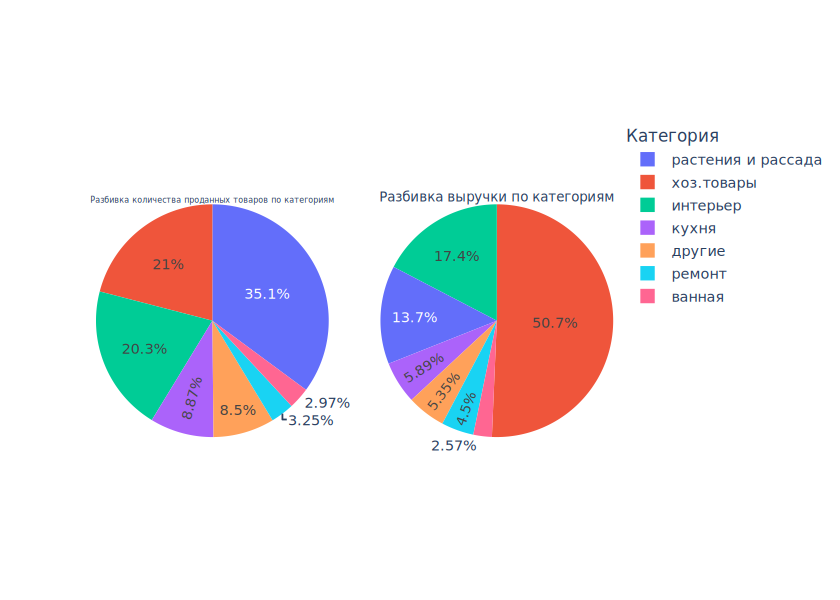

In [30]:
#сгруппируем данные по категориям и посчитаем количество проданных товаров
products_per_cat = data.groupby('category')[['quantity']].agg('sum')
#переименуем столбец
products_per_cat.columns = ['total_count']
products_per_cat = products_per_cat.reset_index()


#сгруппируем данные по категориям и посчитаем выручку для каждой категории
revenue_per_cat = data.groupby('category')[['revenue']].agg('sum')
#переименуем столбец
revenue_per_cat.columns = ['total_revenue']
revenue_per_cat = revenue_per_cat.reset_index()


#круговая диаграмма по собранным данным
labels = products_per_cat['category'].tolist()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, 
                     values=products_per_cat['total_count'], 
                     title='Разбивка количества проданных товаров по категориям'),
              1, 1)
fig.add_trace(go.Pie(labels=labels, 
                     values=revenue_per_cat['total_revenue'], 
                     title='Разбивка выручки по категориям'),
              1, 2)




#оформление графика
fig.update_layout(legend_title = 'Категория')
fig.show()

#display(products_per_cat)

**Вывод:** наибольшее количество товаров приходится на категорию: "растения и рассада" - 35% от общего количества проданных товаров, "интерьер" и "хоз.товары" на втором месте (20% и 21% от общего количества проданных товаров соответственно) при этом более 50% выручки приходится на категорию "хоз.товары", тогда как на категории "растения и рассада" и "интерьер" приходится всего 13,7% и 17,4% выручки от всех проданных товаров магазина.

Посмотрим как распределяется выручка внутри категории:

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
ремонт,92.0,1537.913043,1615.076990,52.0,232.00,974.0,2399.0,7724.0
хоз.товары,1126.0,1414.068384,1729.666926,15.0,487.00,820.0,1649.0,24370.0
ванная,110.0,733.881818,854.265592,15.0,183.25,448.5,974.0,5136.0
интерьер,548.0,995.177007,2431.575050,9.0,118.00,446.0,1162.0,47385.0
кухня,288.0,642.541667,686.131542,22.0,187.00,446.0,831.5,5775.0
другие,372.0,451.521505,1038.647533,9.0,97.00,156.5,402.0,14196.0
растения и рассада,2176.0,197.240349,337.371977,10.0,101.00,135.0,188.0,7679.0


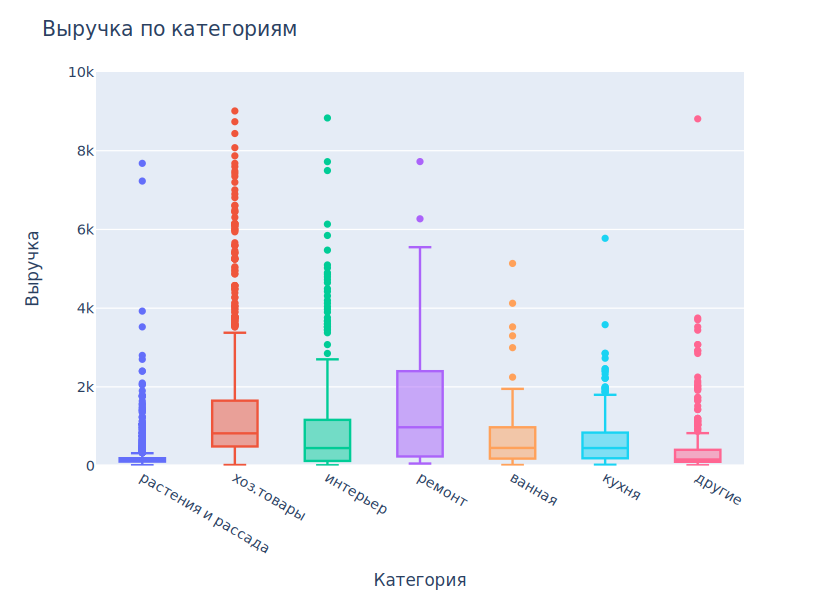

In [31]:
#статистические данные о выручке по категориям
display(
    data.groupby(['category'])['revenue'].describe().sort_values(by='50%', ascending=False)
)

#диаграмма размаха по выручке категории
fig = px.box(data, x='category', y='revenue', color='category')

#оформление графика
fig.update_layout(title='Выручка по категориям',
                   xaxis_title='Категория',
                   yaxis_title='Выручка',
                   showlegend=False)
fig.update_yaxes(range=[0, 10000])
fig.show()

**Вывод:** среднее значение выручки превышает медианное значение внутри каждой категории. Возможно это связано с оптовыми заказами: для каждой категории характерны выбросы в виде больших значений выручки, поэтому будем опираться на медианные значения выручки внутри категории.

Наибольшее медианное значение выручки у категории "ремонт", категория "хоз.товары" на втором месте, а аутсайдером по медианному значению выручки становится категория "растения и рассада" хотя это категория одна из лидеров по количеству проданных товаров.

Также посмотрим какие категории товаров подвержены сезонности. Оценим ежемесячное количество заказов по категориям:

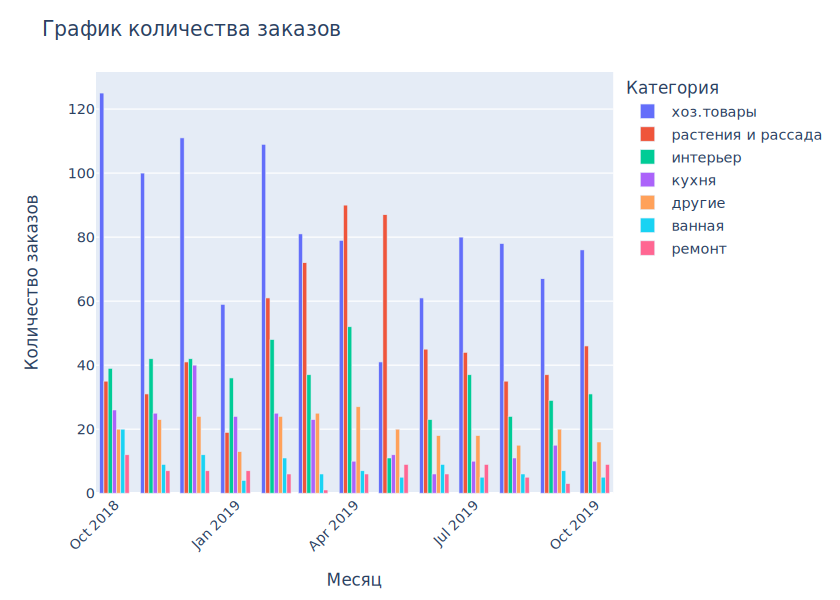

In [32]:
#сгруппируем данные о количестве заказов по категориям для каждого месяца
orders_by_month = data.groupby(['month', 'category'])['order_id'].nunique().reset_index()

#график по собранным данным
fig = px.bar(orders_by_month.sort_values(by='order_id', ascending=False), 
             x = 'month', y = 'order_id',
             color = 'category', barmode = 'group')

#оформление графика
fig.update_layout(title='График количества заказов',
                   xaxis_title='Месяц',
                   yaxis_title='Количество заказов',
                   legend_title = 'Категория')

fig.update_xaxes(tickangle=-45)

fig.show()

**Вывод:** у категории "растения и рассада" явно выражена сезонность с апреля по май включительно. Также стоит отметить что для каждой категории товаров характерен нестабильный спрос для всего периода исследования.

Оценим ежемесячную выручку по категориям:

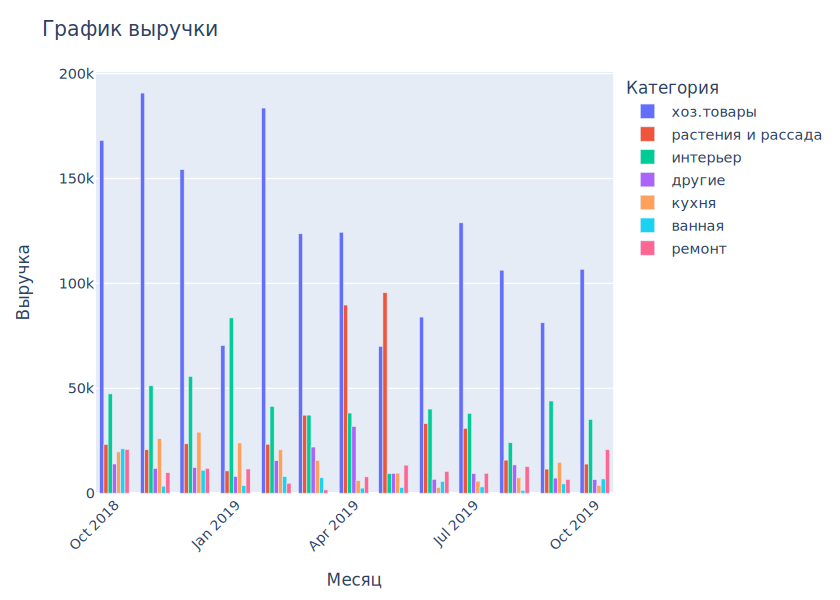

In [33]:
#сгруппируем данные о выручки по категориям для каждого месяца
revenue_by_month = data.groupby(['month', 'category'])['revenue'].sum().reset_index()

#график по собранным данным
fig = px.bar(revenue_by_month.sort_values(by='revenue', ascending=False), 
             x = 'month', y = 'revenue',
             color = 'category', barmode = 'group')

#оформление графика
fig.update_layout(title='График выручки',
                   xaxis_title='Месяц',
                   yaxis_title='Выручка',
                   legend_title = 'Категория')

fig.update_xaxes(tickangle=-45)

fig.show()

**Вывод:** на графике ежемесячной выручки также прослеживается сезонность у категории "растения и рассада" с апреля по май включительно: в эти месяцы показатели выручки максимальные для этой категории.

## Анализ тенденций поведения покупателей

Посмотрим на общие тенденции поведения покупателей: есть ли характерные часы-пик и дни-недели-пик по количеству заказов:

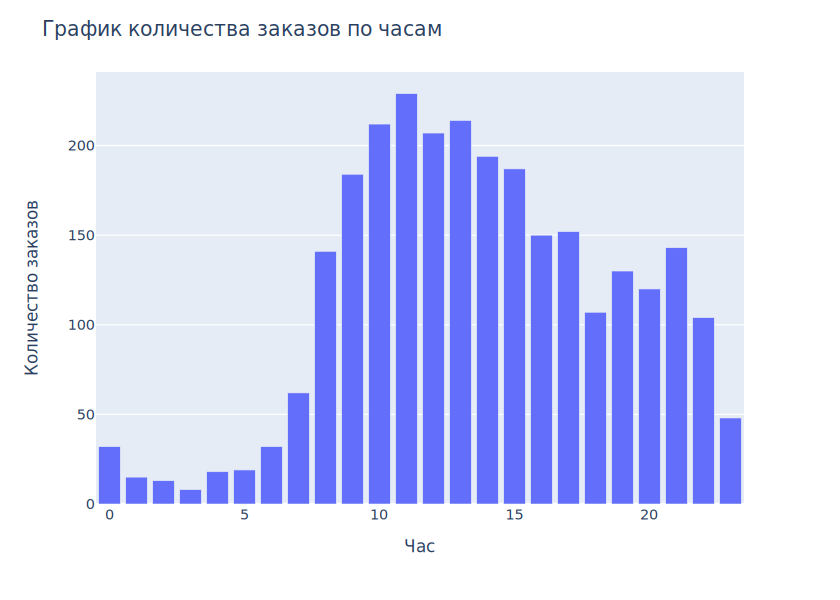

In [34]:
#сгруппируем данные о количестве заказов для каждого часа
orders_by_hour = data.groupby('hour')['order_id'].nunique().reset_index()

#график по собранным данным
fig = px.bar(orders_by_hour, 
             x = 'hour', y = 'order_id')

#оформление графика
fig.update_layout(title='График количества заказов по часам',
                   xaxis_title='Час',
                   yaxis_title='Количество заказов')

fig.show()

**Вывод:** 11:00 - время максимального количества заказов на данных для всего периода исследования (13-ти месяцев), в ночное время заказов меньше всего, на протяжении дня наиболее активное время с 10 до 13 часов.

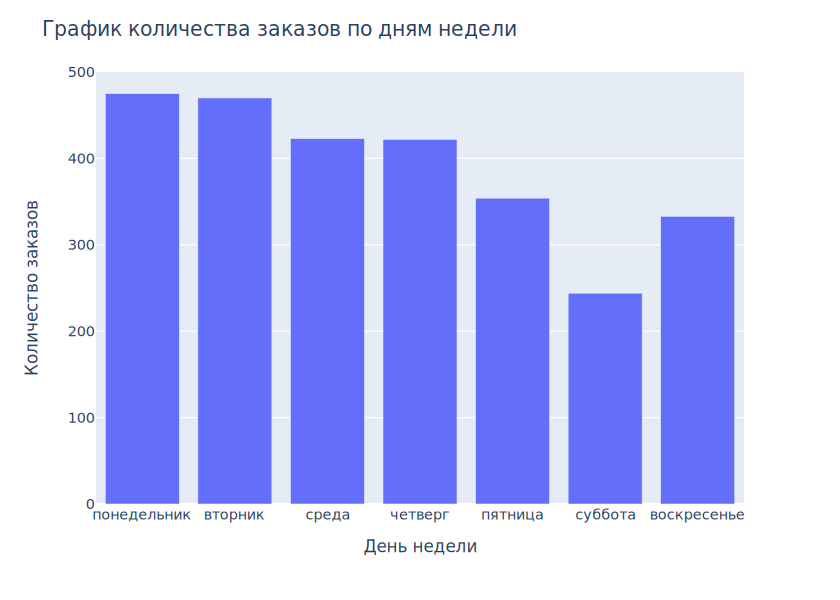

In [35]:
#сгруппируем данные о количестве заказов для каждого дня недели
orders_by_dow = data.groupby('day_of_week')['order_id'].nunique().reset_index()

#дадим числовым обозначениям дней недели названия
def day_name(weekday):
    if weekday == 0:
        return 'понедельник'
    if weekday == 1:
        return 'вторник'
    if weekday == 2:
        return 'среда'
    if weekday == 3:
        return 'четверг'
    if weekday == 4:
        return 'пятница'
    if weekday == 5:
        return 'суббота'
    if weekday == 6:
        return 'воскресенье'

orders_by_dow['day_of_week'] = orders_by_dow['day_of_week'].apply(day_name)

#график по собранным данным
fig = px.bar(orders_by_dow, 
             x = 'day_of_week', y = 'order_id')
             #color = 'category', barmode = 'group')

#оформление графика
fig.update_layout(title='График количества заказов по дням недели',
                   xaxis_title='День недели',
                   yaxis_title='Количество заказов',
                   legend_title = 'Категория')

#fig.update_xaxes(tickangle=-45)

fig.show()

**Вывод:** понедельник и вторник - дни с максимальным количеством заказов, в субботу минимальное количество заказов, что говорит о том что покупатели предпочитают совершать покупки по будням, а не выходным дням.

## Анализ товарного ассортимента. ABC-XYZ-анализ

Проведем АВС-XYZ-анализ товарного ассортимента, он позволит нам выделить какие товары приносят магазину основной доход, а от каких товаров можно отказаться: выделить основной и дополнительный ассортимент.

## ABC-анализ

Первым шагом с помощью АВС-анализа выделим товары в каждой категории, которые приносят основной доход, разделим товарный ассортимент на 3 группы:
* А — дают 80% выручки;
* В — формируют 15% выручки;
* С — дополняют оставшиеся 5%.

Для этого разделим товарный ассортимент по категориям, для каждой товарной позиции определим процент от общей выручки по категории, распределим товары по убыванию этого процента и рассчитаем по каждой товарной позиции долю выручки нарастающим итогом, начиная с тех товаров, которые дают самый существенный вклад.

In [36]:
#ABC-анализ
#выделим уникальные категории
category = data['category'].unique()

#напишем функцию принимающую долю в общей выручки нарастающим итогом и возвращающим группу АВС-анализа
def group_abc(revenue_ratio):
    try:
        if 0.0 <= revenue_ratio <= 80.0:
            return 'A'
        elif 80.0 < revenue_ratio <= 95.0:
            return 'B'
        else:
            return 'C'
    except:
        pass

#создадим пустой датасет чтобы записывать в него результирующие данные по категориям
final_data_abc = pd.DataFrame()

#для каждой категории
for c in category:
    
    #в столбец `revenue_by_product` записываем общую выручку для каждого продукта
    data_abc = data.query('category == @c').groupby('product')[['revenue']].sum()
    data_abc.columns = ['revenue_by_product']
    data_abc = data_abc.reset_index().sort_values(by='revenue_by_product', ascending=False)
    
    #сохраняем в переменной общую выручку категории
    total_revenue_by_category = data_abc['revenue_by_product'].sum()
    
    #в столбец `%_total_revenue` записываем долю в общей выручке каждого продукта
    data_abc['%_total_revenue'] = round(
        data_abc['revenue_by_product'] / total_revenue_by_category * 100, 2)
    #сортируем таблицу по убыванию доли в общей выручке
    data_abc = data_abc.sort_values(by='%_total_revenue', ascending=False)
    
    #в столбец `%_total_revenue_cumulative` записываем долю в общей выручке нарастающим итогом
    data_abc['%_total_revenue_cumulative'] = data_abc['%_total_revenue'].cumsum()
    
    #разбиваем товары на группы при помощи функции group_revenue
    data_abc['group_abc'] = data_abc['%_total_revenue_cumulative'].apply(group_abc)
    
    #выводим данные
    #print(f'Наименование категории: {c}')
    #display(data_abc)
    
    final_data_abc = pd.concat([final_data_abc, data_abc])
#final_data_abc - итоговая таблица с результатами АВС-анализа по всем товарным позициям магазина

Посмотрим как между группами A, B и C распределяется выручка и количество товарных позиций:

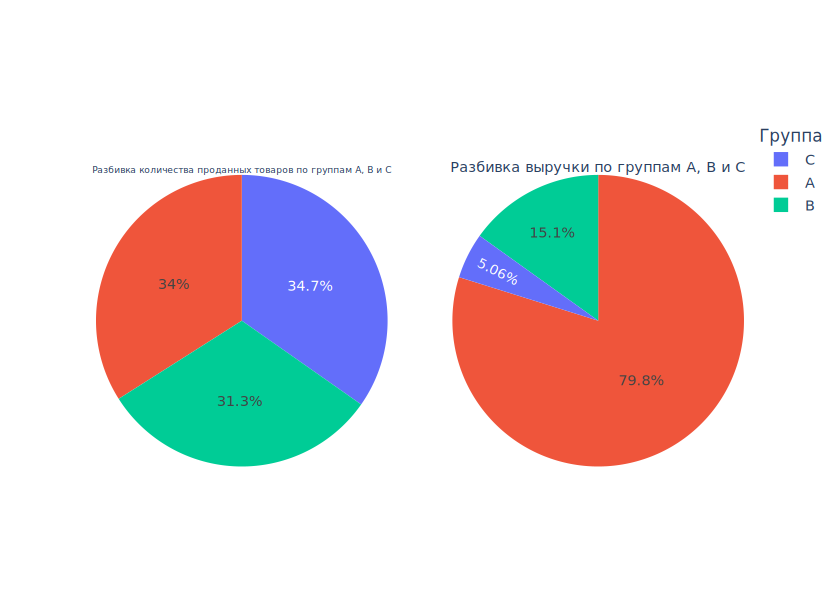

In [37]:
#сгруппируем данные по группами A, B и C и посчитаем количество товарных позиций
products_by_abc = final_data_abc.groupby('group_abc')[['product']].agg('count')
#переименуем столбец
products_by_abc.columns = ['total_count']
products_by_abc = products_by_abc.reset_index()


#сгруппируем данные по группами A, B и C и посчитаем выручку для каждой группы
revenue_by_abc = final_data_abc.groupby('group_abc')[['revenue_by_product']].agg('sum')
#переименуем столбец
revenue_by_abc.columns = ['total_revenue']
revenue_by_abc = revenue_by_abc.reset_index()


#круговая диаграмма по собранным данным
labels = final_data_abc['group_abc'].unique().tolist()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, 
                     values=products_by_abc['total_count'], 
                     title='Разбивка количества проданных товаров по группам А, В и С'),
              1, 1)
fig.add_trace(go.Pie(labels=labels, 
                     values=revenue_by_abc['total_revenue'], 
                     title='Разбивка выручки по группам А, В и С'),
              1, 2)




#оформление графика
fig.update_layout(legend_title = 'Группа')
fig.show()

#display(products_by_abc)

**Вывод:** количество товарных позиций распределяются среди групп А, В, С равномерно примерно по 33% от общего количества товарных позиций, но при этом группа А дает около 80% от общей выручки магазина, группа В - 15%, С - около 5%. 

## XYZ-анализ

Вторым шагом с помощью XYZ-анализа распределим товары в зависимости от стабильности спроса, разделим товарный ассортимент на 3 группы:
* Х — стабильный спрос, объем продаж от месяца к месяцу почти не изменяются.
* Y — условно стабильный спрос, т. е. объемы продаж меняются, но без резких скачков.
* Z — спрос нестабилен, покупатели приобретают товар от случая к случаю.

Для этого разделим товарный ассортимент по категориям, для каждой товарной позиции в категории определим количество проданных единиц за каждый месяц (всего 13 месяцев нашем случае) и среднемесячное количество проданных единиц, рассчитаем стандартное отклонение спроса и коэффициент вариации (чем он меньше тем стабильнее спрос). С помощью коэффициента вариации разделим товарный ассортимент на группы X, Y и Z.

In [38]:
#XYZ-анализ
#напишем функцию принимающую коэффициент вариации каждой товарной позиции и возвращающую группу XYZ-анализа
def group_xyz(cov):
    try:
        if cov <= 0.5:
            return 'X'
        elif cov > 0.5 and cov <= 1:
            return 'Y'
        else:
            return 'Z'
    except:
        pass

#создадим пустой датасет чтобы записывать в него результирующие данные по категориям
final_data_xyz = pd.DataFrame()

#для каждой категории
for c in category:
    #в столбец `quantity_by_product` записываем количество каждого продукта по месяцам
    data_xyz = data.query('category == @c').groupby(['product', 'month'])[['quantity']].sum()
    data_xyz.columns = ['quantity_by_product']
    data_xyz = data_xyz.reset_index()
    
    #изменим форму данных: поместим наименования товаров в строки, 
    #сохраним количество единиц, проданных за каждый месяц, в отдельном столбце
    data_xyz = data_xyz.pivot(
    index='product', columns='month', values='quantity_by_product').add_prefix('m').reset_index().fillna(0)
    
    #в столбец `std_demand` записываем стандартное отклонение спроса
    data_xyz['std_demand'] = data_xyz[[
        'm2018-10-01 00:00:00', 'm2018-11-01 00:00:00', 'm2018-12-01 00:00:00', 
        'm2019-01-01 00:00:00', 'm2019-02-01 00:00:00', 'm2019-03-01 00:00:00', 
        'm2019-04-01 00:00:00', 'm2019-05-01 00:00:00', 'm2019-06-01 00:00:00', 
        'm2019-07-01 00:00:00', 'm2019-08-01 00:00:00', 'm2019-09-01 00:00:00', 'm2019-10-01 00:00:00'
    ]].std(axis=1)
    
    #в столбец `total_demand` записываем общий спрос по каждому товару
    data_xyz['total_demand'] = data_xyz[[
        'm2018-10-01 00:00:00', 'm2018-11-01 00:00:00', 'm2018-12-01 00:00:00', 
        'm2019-01-01 00:00:00', 'm2019-02-01 00:00:00', 'm2019-03-01 00:00:00', 
        'm2019-04-01 00:00:00', 'm2019-05-01 00:00:00', 'm2019-06-01 00:00:00', 
        'm2019-07-01 00:00:00', 'm2019-08-01 00:00:00', 'm2019-09-01 00:00:00', 'm2019-10-01 00:00:00'
    ]].sum(axis = 1)
    
    #в столбец `avg_demand` записываем среднемесячное значение спроса
    data_xyz['avg_demand'] = data_xyz['total_demand'] / 13
    
    #в столбец `cov_demand` записываем коэффициент вариации спроса
    data_xyz['cov_demand'] = data_xyz['std_demand'] / data_xyz['avg_demand']
    
    #разбиваем товары на группы при помощи функции group_xyz
    data_xyz['group_xyz'] = data_xyz['cov_demand'].apply(group_xyz)
    
    #выводим данные
    #print(f'Наименование категории: {c}')
    #display(data_xyz)
    
    final_data_xyz = pd.concat([final_data_xyz, data_xyz])

Посмотрим как распределяются значения коэффициента вариации нашего товарного ассортимента.

In [39]:
display(final_data_xyz['cov_demand'].agg(['min', 'mean', 'max']))

min     0.653709
mean    3.225243
max     3.605551
Name: cov_demand, dtype: float64

Минимальное значение 0.65 говорит нам о том что в группу X со стабильным спроссом не попадает ни один товар из всего товарного ассортимента магазина, это указывает на то что весь товарный ассортимент имеет изменяющийся или сезонный спрос.

In [40]:
final_data_xyz.groupby('group_xyz').agg(
    total_skus=('product', 'nunique'),
    total_demand=('total_demand', 'sum'),    
    std_demand=('std_demand', 'mean'),      
    avg_demand=('avg_demand', 'mean'),
    avg_cov_demand=('cov_demand', 'mean'),
)

,total_skus,total_demand,std_demand,avg_demand,avg_cov_demand
group_xyz,,,,,
Y,10,323.0,2.129762,2.484615,0.866038
Z,2290,8757.0,0.828746,0.294155,3.235545


**Вывод:** группа X, характеризующаяся стабильным спросом отсутствует среди нашего товарного ассортимента, группа Y, которой характерен условно стабильный спрос (без резких скачков) ничтожно малочисленна - всего 10 товарных позиций из всего ассортимента. 

Посмотрим как между группами X распределяется количество проданных единиц товарных позиций:

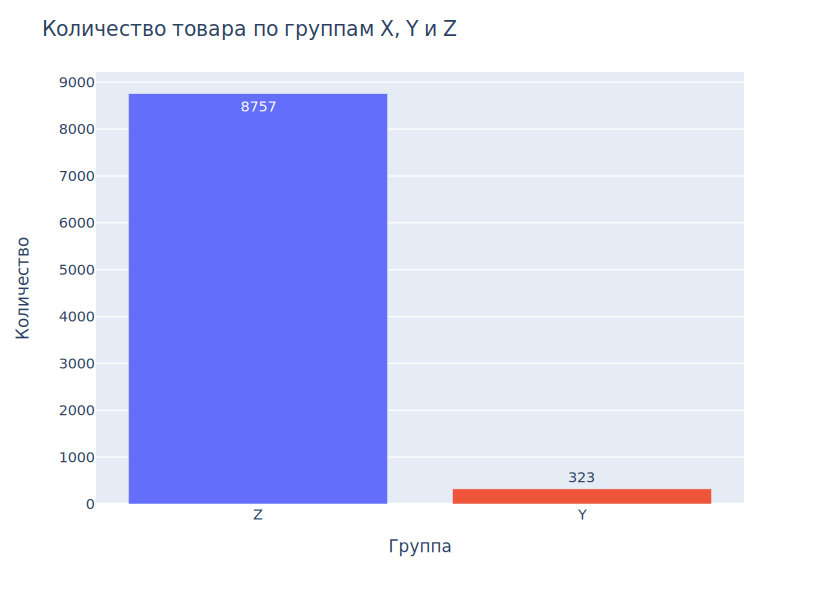

In [41]:
#сгруппируем данные о количестве заказанного товара по группам
quantity_by_xyz = final_data_xyz.groupby('group_xyz')['total_demand'].sum().reset_index()

#график по собранным данным
fig = px.bar(quantity_by_xyz.sort_values(by='total_demand', ascending=False), 
             x = 'group_xyz', y = 'total_demand',
             color = 'group_xyz', text = 'total_demand')

#оформление графика
fig.update_layout(title='Количество товара по группам X, Y и Z',
                   xaxis_title='Группа',
                   yaxis_title='Количество',
                   showlegend = False)


fig.show()

**Вывод:** подавляющее большинство товарного ассортимента имеет нестабильный спрос.

Построим ежемесячные графики спроса для каждой группы X, Y, Z.

Группа: Y


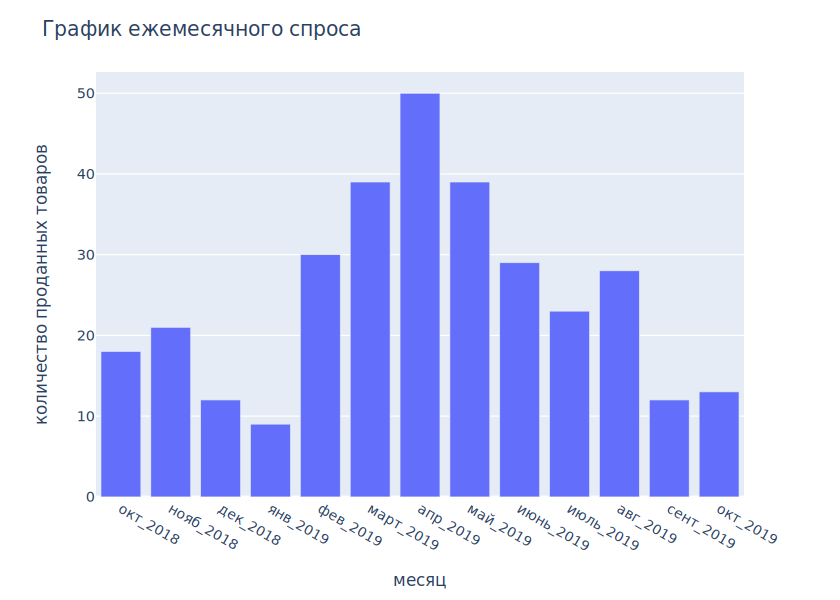

Группа: Z


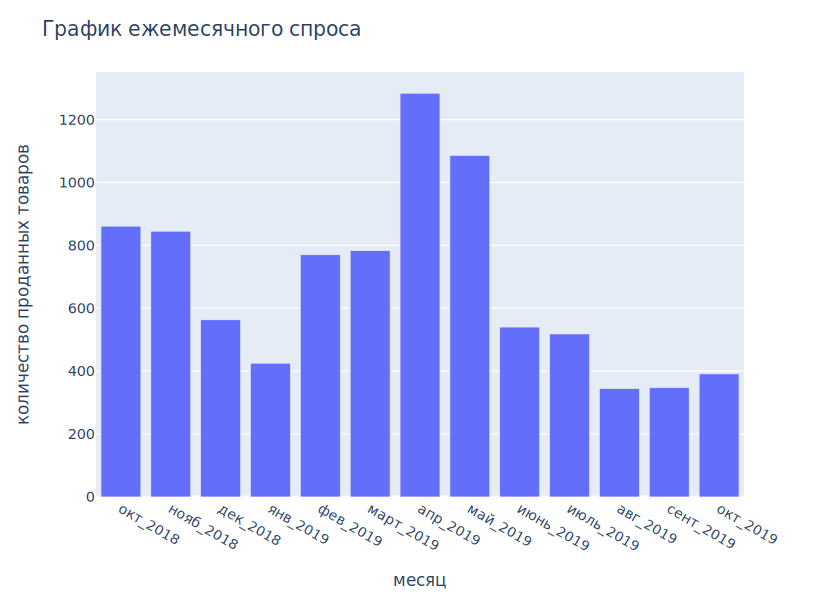

In [42]:
#переименуем месяцы в наиболее удобные
final_data_xyz = final_data_xyz.rename(columns={
        'm2018-10-01 00:00:00': 'окт_2018', 
        'm2018-11-01 00:00:00': 'нояб_2018',
        'm2018-12-01 00:00:00': 'дек_2018', 
        'm2019-01-01 00:00:00': 'янв_2019',
        'm2019-02-01 00:00:00': 'фев_2019',
        'm2019-03-01 00:00:00': 'март_2019',
        'm2019-04-01 00:00:00': 'апр_2019',
        'm2019-05-01 00:00:00': 'май_2019',
        'm2019-06-01 00:00:00': 'июнь_2019',
        'm2019-07-01 00:00:00': 'июль_2019',
        'm2019-08-01 00:00:00': 'авг_2019',
        'm2019-09-01 00:00:00': 'сент_2019',
        'm2019-10-01 00:00:00': 'окт_2019'
})

#сформируем таблицу со спросом для каждого месяца
xyz_monthly = final_data_xyz.groupby('group_xyz').agg(
    окт_2018=('окт_2018', 'sum'),
    нояб_2018=('нояб_2018', 'sum'),
    дек_2018=('дек_2018', 'sum'),
    янв_2019=('янв_2019', 'sum'),
    фев_2019=('фев_2019', 'sum'),
    март_2019=('март_2019', 'sum'),
    апр_2019=('апр_2019', 'sum'),
    май_2019=('май_2019', 'sum'),
    июнь_2019=('июнь_2019', 'sum'),
    июль_2019=('июль_2019', 'sum'),
    авг_2019=('авг_2019', 'sum'),
    сент_2019=('сент_2019', 'sum'),
    окт_2019=('окт_2019', 'sum'),

)

#перевернем таблицу
xyz_monthly = xyz_monthly.unstack('group_xyz').to_frame()
xyz_monthly = xyz_monthly.reset_index().rename(columns={'level_0': 'month', 0: 'demand'})

#сгруппируем данные о спросе для каждого месяца
groups = xyz_monthly['group_xyz'].unique().tolist()

for g in groups:
    print(f'Группа: {g}')
    #график по собранным данным
    fig = px.bar(xyz_monthly.query('group_xyz == @g'), 
                 x = 'month', y = 'demand')
    #оформление графика
    fig.update_layout(title='График ежемесячного спроса',
                      xaxis_title='месяц',
                      yaxis_title='количество проданных товаров')
    fig.show()

**Вывод:** на графиках видно что спрос действительно нестабилен и резкие скачки присущи и группе Y и группе Z. Также можно отметить что в январе покупательская активность снижается.

## Результаты ABC-XYZ-анализа

Объединим данные ABC-XYZ-анализов в один датасет:

In [43]:
#удалим лишние столбцы
final_data_abc = final_data_abc.drop(['%_total_revenue', '%_total_revenue_cumulative'], axis=1)
final_data_xyz = final_data_xyz.drop([
    'окт_2018', 'нояб_2018','дек_2018', 
    'янв_2019','фев_2019','март_2019',
    'апр_2019','май_2019','июнь_2019',
    'июль_2019','авг_2019','сент_2019',
    'окт_2019','std_demand', 
    'avg_demand', 'cov_demand'
], axis=1)

#объединение с удалением ненужных столбцов
full_data = final_data_abc.merge(final_data_xyz, on='product')
full_data['group'] = full_data[['group_abc', 'group_xyz']].sum(axis = 1)
full_data = full_data.drop(['group_abc', 'group_xyz'], axis=1)
full_data['category'] = full_data['product'].apply(categorize)

Первые 5 строк результирующей таблицы ABC-XYZ-анализа.
Таблица содержит следующие данные:
* `product` - наименование товарной позиции
* `revenue_by_product` - общая выручка с товарной позиции за весь период исследования
* `total_demand` - количество проданных единиц товарной позиции за весь период исследования
* `group` - группа ABC-XYZ-анализа
* `category` - категория товарной позиции

In [44]:
full_data.head()

,product,revenue_by_product,total_demand,group,category
0,пеларгония зональная диам. 12 см сиреневый пол...,10780.0,63.0,AY,растения и рассада
1,пеларгония розебудная red pandora укорененный ...,10655.0,79.0,AZ,растения и рассада
2,пеларгония зональная диам. 12 см красная махровая,10514.0,63.0,AZ,растения и рассада
3,эвкалипт гунни d-17 см h-60 см,9866.0,6.0,AZ,растения и рассада
4,новогоднее дерево ель сербская d-21 см h-60 см,9441.0,9.0,AZ,растения и рассада


In [45]:
full_data['group'].unique()

array(['AY', 'AZ', 'BZ', 'CZ'], dtype=object)

По результатам ABC-XYZ-анализа наш товарный ассортимент распределился по 4-м группам:
* AY - дают 80% выручки, имеют условно стабильный спрос
* AZ - дают 80% выручки, спрос нестабилен
* BZ - дают 15% выручки, спрос нестабилен
* CZ - дают 5% выручки, спрос нестабилен

Посмотрим как между группами ABC-XYZ-анализа распределяется выручка и количество товарных позиций:

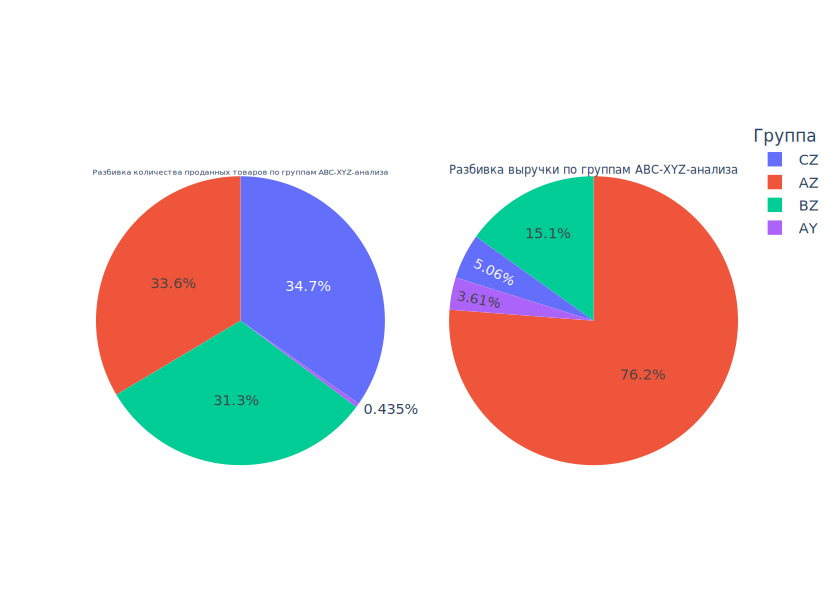

In [46]:
#сгруппируем данные по группами ABC-XYZ и посчитаем количество товарных позиций
products = full_data.groupby('group')[['product']].agg('count')
#переименуем столбец
products.columns = ['total_count']
products = products.reset_index()


#сгруппируем данные по группами ABC-XYZ и посчитаем выручку для каждой группы
revenue = full_data.groupby('group')[['revenue_by_product']].agg('sum')
#переименуем столбец
revenue.columns = ['total_revenue']
revenue = revenue.reset_index()


#круговая диаграмма по собранным данным
labels = full_data['group'].unique().tolist()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, 
                     values=products['total_count'], 
                     title='Разбивка количества проданных товаров по группам ABC-XYZ-анализа'),
              1, 1)
fig.add_trace(go.Pie(labels=labels, 
                     values=revenue['total_revenue'], 
                     title='Разбивка выручки по группам ABC-XYZ-анализа'),
              1, 2)




#оформление графика
fig.update_layout(legend_title = 'Группа')
fig.show()

**Вывод:** количество единиц товарных позиций распределяется приблизительно поравну между группами AZ, BZ и CZ - от 31.3 до 34.7%, доля проданных товаров группы AY всего 0.43%. При этом доля выручки группы AY составляет 3.61%, группы AZ - 76.2%, группы BZ - 15%, а группы CZ - 5%.

Также посмотрим как категории товаров разбиваются по группам ABC-XYZ-анализа.

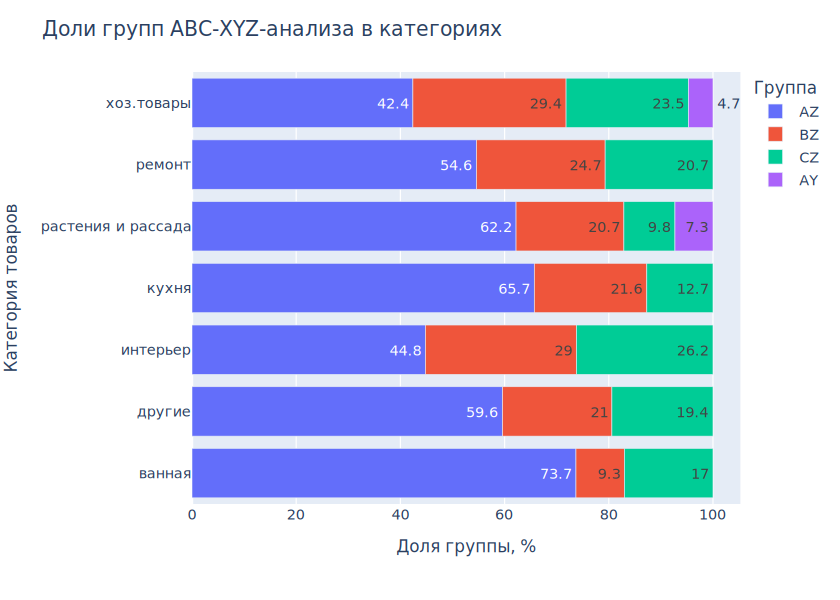

In [47]:
#готовим данные для графика
#сгруппируем данные по группе и категории, найдем количество товарных позиций каждой категории
#присоединим общее количество произведений каждого периода
cat_by_group = full_data.groupby(['category', 'group']).agg(count=(
    'total_demand', 'sum'
)).reset_index().merge(full_data.groupby('category').agg(
    total=('total_demand', 'sum')).reset_index(), how='left')

#cat_by_group

#ищем долю группы в категории
cat_by_group['share'] = (
    cat_by_group['count'] / cat_by_group['total'] * 100
).round(1)
 

#график       
fig = px.bar(
    cat_by_group, 
    x='share', 
    y='category', 
    color='group',  
    text='share')

#оформление графика
fig.update_layout(title='Доли групп ABC-XYZ-анализа в категориях',
                   xaxis_title='Доля группы, %',
                   yaxis_title='Категория товаров',
                   legend_title = 'Группа')

fig.show()

**Вывод:** группы **AY** - дают 80% выручки, имеют условно стабильный спрос, характерны лишь для двух категорий: "хоз.товары" и "растения и рассада". <br>
Доли группы **AZ** - дают 80% выручки имеют нестабильный спрос, более 42% для всех категорий товарного ассортимента. <br>
Группа **BZ** - формируют 15% выручки имеют нестабильный спрос, присуща каждой категоии товарного ассортимента, ее доли от 9.3 до 29.4% в зависимости от категории. <br>
Группа **СZ** - формируют 5% выручки имеют нестабильный спрос, также присуща каждой категоии товарного ассортимента, ее доли от 9.8 до 26.2% в зависимости от категории.

## Проверка статистических гипотез

Проведем статистический анализ данных, проверим приведенные ниже гипотезы:
1. Среднее значение выручки категорий "ванная" и "кухня" одинаковые по понедельникам.
2. Среднее значение выручки интернет магазина в будние дни и в выходные одинаковые.

Иными словами мы будем проверять гипотезы о равенстве средних двух генеральных совокупностей: исследовать значения выручки различных категорий и различных дней и на основании взятых из них случайных выборок делать вывод о том, считать ли эти значения выручки одинаковыми или нет.

Инструментом для проверки гипотезы станет t-тест, мы можем его использовать т.к. исследуемые генеральные совокупности не зависят друг от друга, данных достаточно чтобы считать что средние выборок нормально распределены, однако существуют сомнения, что выборки имеют одинаковый размер и дисперсии у совокупностей одинаковые, поэтому укажем параметр equal_var как False (благодаря этому тест посчитает дисперсии выборок по отдельности)

### Среднее значение выручки категорий "растения и рассада" и "интерьер" одинаковые по понедельникам.

Сформулируем нулевую и альтернативную гипотезы:
```
H_0: Выручка категории "ванная" по понедельникам = выручке категории "кухня" по понедельникам
H_a: Выручка категории "ванная" по понедельникам ≠ выручке категории "кухня" по понедельникам
```

In [48]:
#импортируем библиотеку необходимую нам в решении задач исследования
from scipy import stats as st

In [49]:
#подготовим данные
monday_revenue_bathroom = data.query('category == "ванная" & day_of_week == 0')['revenue']
monday_revenue_kitchen = data.query('category == "кухня" & day_of_week == 0')['revenue']

#проверим гипотезу с помощью t-теста
results = st.ttest_ind(monday_revenue_bathroom, monday_revenue_kitchen, equal_var=False)
#зададим уровень статистической значимости
alpha = .05

#выводим результаты
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую теорию')
else:
    print('Не получилось отвергнуть нулевую теорию')

0.4634954199393727
Не получилось отвергнуть нулевую теорию


**Вывод:** на имеющихся данных, на уровне значимости 5% есть основания принять нулевую гипотезу о равенстве средних значений выручки категорий "кухня" и "ванная" по понедельникам.

Проиллюстрируем наш вывод:

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
кухня,41.0,922.536585,929.225594,187.0,375.00,716.0,1056.0,5775.0
ванная,22.0,742.181818,919.120783,15.0,151.75,426.5,1083.5,4124.0


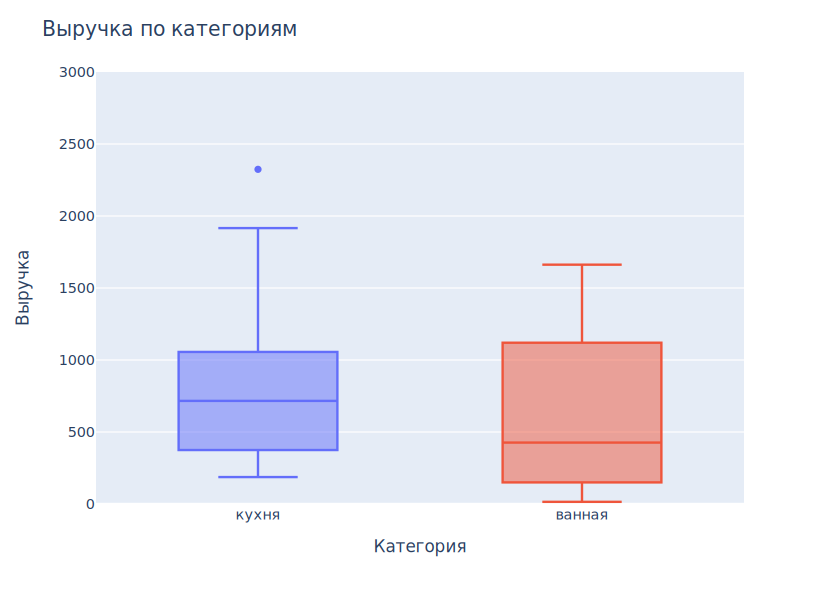

In [50]:
#соберем данные
monday_revenue_by_cat = data.query(
    '(category == "ванная" | category == "кухня") & day_of_week == 0')

#статистические данные о выручке по категориям
display(
    monday_revenue_by_cat.groupby(['category'])['revenue'].describe().sort_values(by='50%', ascending=False)
)

#диаграмма размаха по выручке категории
fig = px.box(monday_revenue_by_cat, x='category', y='revenue', color='category')

#оформление графика
fig.update_layout(title='Выручка по категориям',
                   xaxis_title='Категория',
                   yaxis_title='Выручка',
                   showlegend=False)
fig.update_yaxes(range=[0, 3000])
fig.show()

**Вывод:** среднее значение выручки категории "кухня" существенно выше среднего значения выручки категории "ванная"

###  Среднее значение выручки интернет магазина в будние дни и в выходные одинаковые.

Сформулируем нулевую и альтернативную гипотезы:
```
H_0: Выручка интернет-магазина в будние дни = выручке интернет магазина в выходные дни.
H_a: Выручка интернет-магазина в будние дни ≠ выручке интернет магазина в выходные дни.
```

In [51]:
#подготовим данные
workday_revenue = data.query('day_of_week != 5 & day_of_week != 6')['revenue']
weekend_revenue = data.query('day_of_week == 5 | day_of_week == 6')['revenue']

#проверим гипотезу с помощью t-теста
results= st.ttest_ind(workday_revenue, weekend_revenue, equal_var=False)
#зададим уровень статистической значимости
alpha = .05

#выводим результаты
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую теорию')
else:
    print('Не получилось отвергнуть нулевую теорию')


0.0062250498650501945
Отвергаем нулевую теорию


**Вывод:** на имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений выручки по будням и по выходным дням в пользу альтернативной гипотезы.

Проиллюстрируем наши выводы:

,count,mean,std,min,25%,50%,75%,max
day_name,,,,,,,,
будни,3704.0,689.265929,1474.475100,9.0,120.0,194.0,734.0,47385.0
выходные,1008.0,584.310516,943.132276,10.0,114.0,188.0,674.0,8437.0


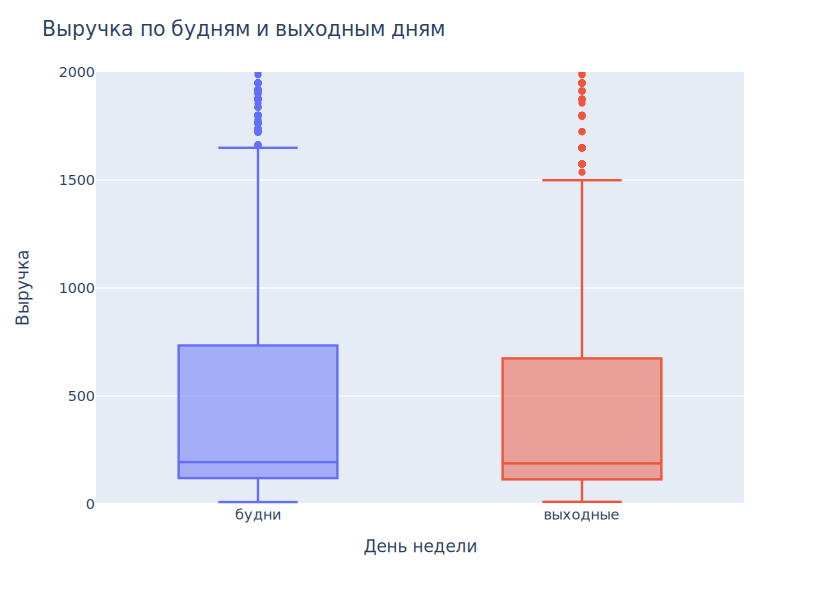

In [52]:
#разделим дни недели на будние и выходные с помощью функции
def weekday_name(weekday):
    if weekday == 0:
        return 'будни'
    if weekday == 1:
        return 'будни'
    if weekday == 2:
        return 'будни'
    if weekday == 3:
        return 'будни'
    if weekday == 4:
        return 'будни'
    if weekday == 5:
        return 'выходные'
    if weekday == 6:
        return 'выходные'

data['day_name'] = data['day_of_week'].apply(weekday_name)
    
#статистические данные о выручке по категориям
display(
    data.groupby(['day_name'])['revenue'].describe().sort_values(by='50%', ascending=False)
)

#диаграмма размаха по выручке категории
fig = px.box(data, x='day_name', y='revenue', color='day_name')

#оформление графика
fig.update_layout(title='Выручка по будням и выходным дням',
                   xaxis_title='День недели',
                   yaxis_title='Выручка',
                   showlegend=False)
fig.update_yaxes(range=[0, 2000])
fig.show()

**Вывод:** среднее значение выручки интернет-магазина по будням выше среднего значения выручки интернет магазина по выходным.

## Итоги исследования


Резюмируя проделанную работу:
1. При разбивке товаров на категории были выявлены следующие особенности:
- основные категории по количеству проданных товаров: "растения и рассада", "интерьер" и "хоз.товары" примерно по 23% от общего количество проданных товаров интернет-магазина
- категория "хоз.товары" приносит около 50% выручки интернет-магазина
- категории "растения и рассада" характерна сезонность: максимальный спрос приходит на апрель-май
2. Анализ пользовательской активности показал:
- час-пик приходится на 11:00 дня
- пиковый день недели: понедельник, в этот день количество заказов максимальное
3. Результатом АВС-XYZ-анализа стало распределение товарного ассортимента на 4 группы:
* AY - дают 80% выручки, имеют условно стабильный спрос
* AZ - дают 80% выручки, спрос нестабилен
* BZ - дают 15% выручки, спрос нестабилен
* CZ - дают 5% выручки, спрос нестабилен<br>
<br>
АВС-XYZ-анализ выявил следующую особенность:
- весь товарный ассортимент магазина имеет изменяющийся или сезонный спрос.
- товарные позиции с условно стабильным спросом присущи только 2-м категориям товаров: "хоз.товары" и "растения и рассада"<br>
4. **Рекомендации:** 
* Группы AY, AZ, BZ можно отнести к **основному ассортименту** интернет-магазина: на них приходится около 65% товарных позиций и 95% выручки. 
* Группу CZ можно отнести к **дополнительному ассортименту** интернет-магазина: на нее приходится около 35% товарных позиций и всего 5% выручки.
5. В ходе статистического анализа на имеющихся данных, на уровне значимости 5%, удалось установить:
* средние значения выручки категорий "кухня" и "ванная" по понедельникам одинаковы.
* средние значения выручки интернет-магазина по будням и по выходным дням не равны.

Ссылка на дашборд: <https://public.tableau.com/app/profile/kseniia.savinkova/viz/YP_final_project_16830282133040/Dashboard1>

Ссылка на презентацию: <https://disk.yandex.ru/i/6EAP8STRSFKtxA>